In [1]:
from matplotlib import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce


In [2]:
df = pd.read_csv('/data/kebl6672/dpo-toxic-general/toxicity/llama3_all_neuron_metrics_new.csv')
df.head()

,layer_idx,neuron_idx,pt_projection_value,pt_activation_value,dpo_projection_value,dpo_activation_value,pt_cosine_similarity,dpo_cosine_similarity,projection_diff,activation_diff
0,6,7511,-0.069397,-0.002005,-0.041948,-0.001202,0.019012,0.019012,-0.027449,-0.000803
1,9,14198,-0.271240,-0.018799,-0.280962,-0.019440,0.007317,0.007317,0.009721,0.000641
2,27,1972,-0.009071,0.000284,-0.040361,0.001255,-0.016388,-0.016388,0.031290,-0.000971
3,1,751,-0.001370,-0.000348,-0.001548,-0.000343,0.002012,0.002012,0.000177,-0.000005
4,4,7438,0.093811,-0.004955,0.097945,-0.005154,-0.009727,-0.009727,-0.004133,0.000198


In [3]:
merged_df = df

merged_df.replace([float("inf"), float("-inf")], np.nan, inplace=True)
merged_df.dropna(inplace=True)  # Removes affected rows

merged_df['projection_diff'] = merged_df['pt_projection_value'] - merged_df['dpo_projection_value']
merged_df['activation_diff'] = merged_df['pt_activation_value'] - merged_df['dpo_activation_value']

# Display the first few rows of the DataFrame
print(merged_df.head())

   layer_idx  neuron_idx  pt_projection_value  pt_activation_value  \
0          6        7511            -0.069397            -0.002005   
1          9       14198            -0.271240            -0.018799   
2         27        1972            -0.009071             0.000284   
3          1         751            -0.001370            -0.000348   
4          4        7438             0.093811            -0.004955   

   dpo_projection_value  dpo_activation_value  pt_cosine_similarity  \
0             -0.041948             -0.001202              0.019012   
1             -0.280962             -0.019440              0.007317   
2             -0.040361              0.001255             -0.016388   
3             -0.001548             -0.000343              0.002012   
4              0.097945             -0.005154             -0.009727   

   dpo_cosine_similarity  projection_diff  activation_diff  
0               0.019012        -0.027449        -0.000803  
1               0.007317      

##### Compute max and sum of projection

In [4]:
# Calculate the sum of non-negative values of 'projection_diff'
sum_non_negative = merged_df[merged_df['projection_diff'] >= 0]['projection_diff'].sum()

# Calculate the sum of all values of 'projection_diff'
sum_all = merged_df['projection_diff'].sum()

# Print the results
print(f"Sum of non-negative values: {sum_non_negative}")
print(f"Sum of all values: {sum_all}")

Sum of non-negative values: 2876.252004509066
Sum of all values: 116.11704970331024


In [5]:
# Count rows where projection_diff is positive
positive_count = (merged_df["projection_diff"] > 0).sum()

# Total number of rows
total_count = len(merged_df)

# Compute percentage
percentage_positive = (positive_count / total_count) * 100

print(positive_count)
print(f"Percentage of rows with positive projection_diff: {percentage_positive:.2f}%")


240738
Percentage of rows with positive projection_diff: 53.01%


In [6]:
# Total number of activations
total = len(df)

# Count positive and negative activations
num_positive = (df["pt_activation_value"] > 0).sum()
num_negative = (df["pt_activation_value"] < 0).sum()

# Compute percentages
percent_positive = (num_positive / total) * 100
percent_negative = (num_negative / total) * 100

# Print results
print(f"Positive activations: {percent_positive:.2f}%")
print(f"Negative activations: {percent_negative:.2f}%")

Positive activations: 50.04%
Negative activations: 49.96%


In [8]:
tuples_list = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if (row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] > 0 and row['activation_diff'] < 0) or # AP+
       (row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] < 0 and row['activation_diff'] < 0) or # AN-
       (row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] < 0 and row['activation_diff'] > 0) or # TN+
       (row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] > 0 and row['activation_diff'] > 0) # TP-    
]

print(len(tuples_list))

226378


In [10]:
tuples_list = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if (row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] > 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0) or # AP+
       (row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] < 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0) or # AN-
       (row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] < 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0) or # TN+
       (row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] > 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0) # TP-    
]

print(len(tuples_list))

224679


In [11]:
# Define each group
ap_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] > 0 and row['activation_diff'] < 0
]

an_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] < 0 and row['activation_diff'] < 0
]

tn_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] < 0 and row['activation_diff'] > 0
]

tp_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] > 0 and row['activation_diff'] > 0
]

# Count each
count_ap = len(ap_pos)
count_an = len(an_neg)
count_tn = len(tn_pos)
count_tp = len(tp_neg)
total = count_ap + count_an + count_tn + count_tp

# Print proportions
print(f"AP+ count: {count_ap} ({count_ap / total:.1%})")
print(f"AN- count: {count_an} ({count_an / total:.1%})")
print(f"TN+ count: {count_tn} ({count_tn / total:.1%})")
print(f"TP- count: {count_tp} ({count_tp / total:.1%})")
print(f"Total: {total}")


AP+ count: 55496 (24.5%)
AN- count: 57810 (25.5%)
TN+ count: 55318 (24.4%)
TP- count: 57754 (25.5%)
Total: 226378


In [12]:
# Define each group with projection_diff > 0 (i.e. reduces toxicity projection)

# Anti-toxic aligned, Pos activated → More positive (AP+)
ap_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] > 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0
]

# Anti-toxic aligned, Pos activated → Less positive (AP-) 
ap_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] > 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0
]

# Anti-toxic aligned, Neg activated → Less negative (AN-)
an_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] < 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0
]

# Anti-toxic aligned, Neg activated → More negative (AN+)
an_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] < 0 and row['pt_activation_value'] < 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0
]

# Toxic-aligned, Neg activated → More negative (TN+)
tn_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] < 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0
]

# Toxic aligned, Neg activated → Less negative  (TN-)
tn_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] < 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0
]

# Toxic-aligned, Pos activated → Less positive (TP-)
tp_neg = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] > 0 and row['activation_diff'] > 0 and row['projection_diff'] > 0
]

# Toxic aligned, Pos activated → More positive (TP+)
tp_pos = [
    (int(row['layer_idx']), int(row['neuron_idx']), row['dpo_activation_value'])
    for _, row in df.iterrows()
    if row['pt_cosine_similarity'] > 0 and row['pt_activation_value'] > 0 and row['activation_diff'] < 0 and row['projection_diff'] > 0
]

# Count all
counts = {
    'AP+': len(ap_pos),
    'AN-': len(an_neg),
    'TN+': len(tn_pos),
    'TP-': len(tp_neg),
    'AP-': len(ap_neg),
    'AN+': len(an_pos),
    'TN-': len(tn_neg),
    'TP+': len(tp_pos),
}
total = sum(counts.values())

# Print proportions
for name in ['TP-', 'TP+', 'TN-', 'TN+', 'AN-', 'AN+', 'AP-', 'AP+']:
    print(f"{name} count: {counts[name]} ({counts[name] / total:.1%})")
print(f"Total: {total}")


TP- count: 57322 (23.9%)
TP+ count: 3659 (1.5%)
TN- count: 3678 (1.5%)
TN+ count: 54918 (22.9%)
AN- count: 57372 (24.0%)
AN+ count: 3652 (1.5%)
AP- count: 3792 (1.6%)
AP+ count: 55067 (23.0%)
Total: 239460


#### Are projection changes random by cossim?

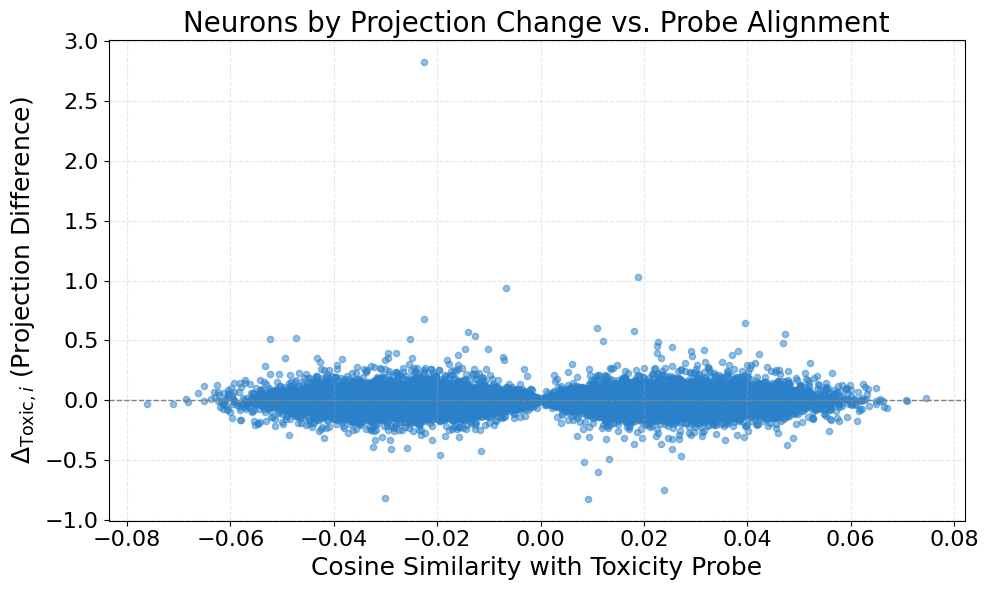

In [10]:
plt.figure(figsize=(10, 6))

# Scatter plot: cosine similarity vs. projection difference
plt.scatter(df["pt_cosine_similarity"], df["projection_diff"],
            alpha=0.5, s=20, color="#2A81CA", label=r"$\Delta_{\mathrm{Toxic}, i}$")

# Plot zero line for reference
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Cosine Similarity with Toxicity Probe", fontsize=18)
plt.ylabel(r"$\Delta_{\mathrm{Toxic}, i}$ (Projection Difference)", fontsize=18)
plt.title("Neurons by Projection Change vs. Probe Alignment", fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(fontsize=16)

plt.tight_layout()
plt.show()

#### Per-layer plots

In [4]:
df = merged_df

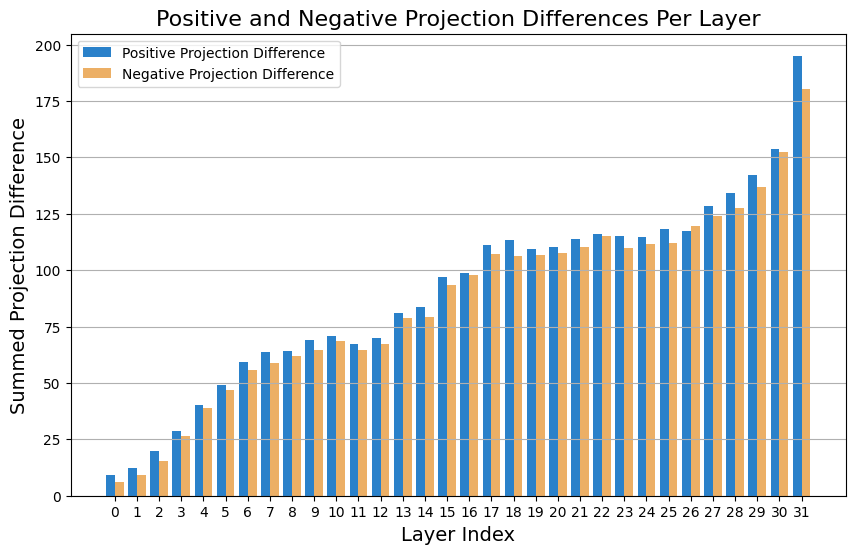

In [34]:
# Compute per-layer sum of positive and negative projection differences separately
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Compute projection difference at the neuron level before summing at the layer level
df["projection_diff"] = df["pt_projection_value"] - df["dpo_projection_value"]

# Aggregate separately for positive and negative projection differences
positive_projection_sums = df[df["projection_diff"] > 0].groupby("layer_idx")["projection_diff"].sum().reset_index()
negative_projection_sums = df[df["projection_diff"] < 0].groupby("layer_idx")["projection_diff"].sum().abs().reset_index()

# Merge with the main layer index to ensure all layers are represented
layer_sums = layer_sums[["layer_idx"]].merge(positive_projection_sums, on="layer_idx", how="left").merge(
    negative_projection_sums, on="layer_idx", how="left", suffixes=("_positive", "_negative")
)

# Fill NaN values with 0
layer_sums.fillna(0, inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as side-by-side bars
width = 0.4  
plt.bar(layer_sums["layer_idx"] - width/2, layer_sums["projection_diff_positive"], width=width, label="Positive Projection Difference", color="#2A81CA")
plt.bar(layer_sums["layer_idx"] + width/2, layer_sums["projection_diff_negative"], width=width, label="Negative Projection Difference", color="#ECAF65")

plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Summed Projection Difference", fontsize=14)
plt.title("Positive and Negative Projection Differences Per Layer", fontsize=16)
plt.xticks(layer_sums["layer_idx"])  # Ensure all layers are visible on x-axis
plt.legend()
plt.grid(axis="y")

plt.show()

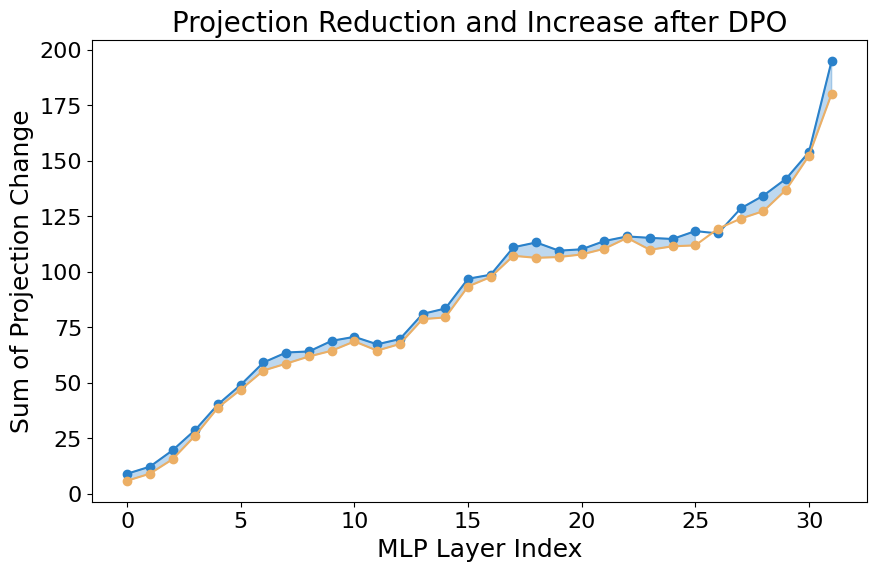

In [13]:
# Compute per-layer sum of positive and negative projection differences separately
layer_sums = df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Compute projection difference at the neuron level before summing at the layer level
df["projection_diff"] = df["pt_projection_value"] - df["dpo_projection_value"]

# Aggregate separately for positive and negative projection differences
positive_projection_sums = df[df["projection_diff"] > 0].groupby("layer_idx")["projection_diff"].sum().reset_index()
negative_projection_sums = df[df["projection_diff"] < 0].groupby("layer_idx")["projection_diff"].sum().abs().reset_index()

# Merge with the main layer index to ensure all layers are represented
layer_sums = layer_sums[["layer_idx"]].merge(positive_projection_sums, on="layer_idx", how="left").merge(
    negative_projection_sums, on="layer_idx", how="left", suffixes=("_positive", "_negative")
)

# Fill NaN values with 0 (for layers with no positive or negative values)
layer_sums.fillna(0, inplace=True)

# Plot the data as line charts with shading between them
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as line plots
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
         label="Reduced Projection", color="#2A81CA", marker='o', linestyle='-')
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff_negative"], 
         label="Increased Projection", color="#ECAF65", marker='o', linestyle='-')

# Fill the area between the two lines
plt.fill_between(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
                 layer_sums["projection_diff_negative"],
                 where=(layer_sums["projection_diff_positive"] > layer_sums["projection_diff_negative"]), 
                 color="#2A81CA", alpha=0.3, label="Reduction > Increase")

plt.fill_between(layer_sums["layer_idx"], layer_sums["projection_diff_positive"], 
                 layer_sums["projection_diff_negative"],
                 where=(layer_sums["projection_diff_positive"] < layer_sums["projection_diff_negative"]), 
                 color="#ECAF65", alpha=0.3, label="Increase > Reduction")

# plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
#                  0, color="#ECAF65", alpha=0.2, label="Under Increased Projection")

plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Sum of Projection Change", fontsize=18)
plt.title("Projection Reduction and Increase after DPO", fontsize=20)
# plt.xticks(layer_sums["layer_idx"], fontsize=12) 
plt.xticks(np.arange(min(layer_sums["layer_idx"]), max(layer_sums["layer_idx"]) + 1, 5), fontsize=16) 
plt.yticks(fontsize=16)  
# plt.legend(fontsize=16)

plt.show()


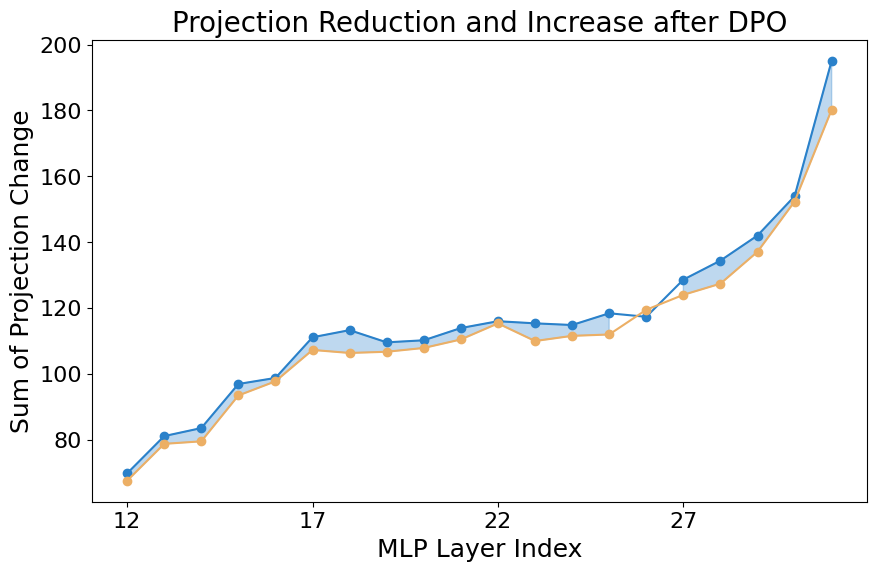

In [9]:
# Filter the data to show only layer 12 onwards
layer_sums_filtered = layer_sums[layer_sums["layer_idx"] >= 12]

# Plot the data as line charts with shading between them
plt.figure(figsize=(10, 6))

# Plot positive and negative projection differences as line plots
plt.plot(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
         label="Reduced Projection", color="#2A81CA", marker='o', linestyle='-')
plt.plot(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
         label="Increased Projection", color="#ECAF65", marker='o', linestyle='-')

# Fill the area between the two lines
plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
                 layer_sums_filtered["projection_diff_negative"],
                 where=(layer_sums_filtered["projection_diff_positive"] > layer_sums_filtered["projection_diff_negative"]), 
                 color="#2A81CA", alpha=0.3, label="Reduction > Increase")

plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_positive"], 
                 layer_sums_filtered["projection_diff_negative"],
                 where=(layer_sums_filtered["projection_diff_positive"] < layer_sums_filtered["projection_diff_negative"]), 
                 color="#ECAF65", alpha=0.3, label="Increase > Reduction")

# plt.fill_between(layer_sums_filtered["layer_idx"], layer_sums_filtered["projection_diff_negative"], 
#                  0, color="#ECAF65", alpha=0.2, label="Under Increased Projection")

plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Sum of Projection Change", fontsize=18)
plt.title("Projection Reduction and Increase after DPO", fontsize=20)
plt.xticks(layer_sums_filtered["layer_idx"], fontsize=16)  
plt.yticks(fontsize=16)  
# plt.legend()

plt.show()

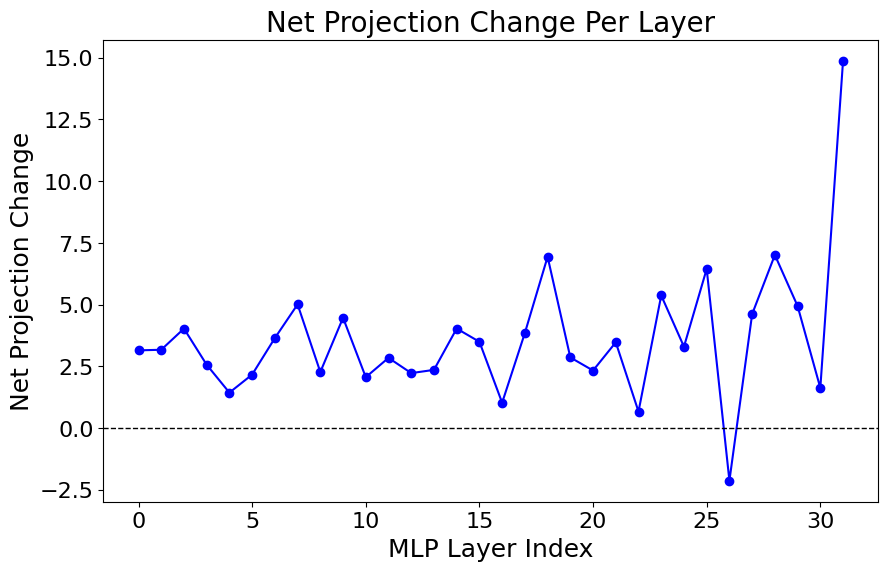

In [15]:
# Compute per-layer projection difference
layer_sums = merged_df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

layer_sums["projection_diff"] = layer_sums["pt_projection_value"] - layer_sums["dpo_projection_value"]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Projection Difference
plt.plot(layer_sums["layer_idx"], layer_sums["projection_diff"], label="Net Projection Change", marker='o', linestyle='-', color='blue')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color="black", linestyle="--", linewidth=1)
# plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.8)  # Lighter gray grid

# Labels and title
plt.xlabel("MLP Layer Index", fontsize=18)
plt.ylabel("Net Projection Change", fontsize=18)
plt.title("Net Projection Change Per Layer", fontsize=20)
# plt.legend(fontsize=16)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

# Show plot
plt.show()


##### Per-layer projection plot

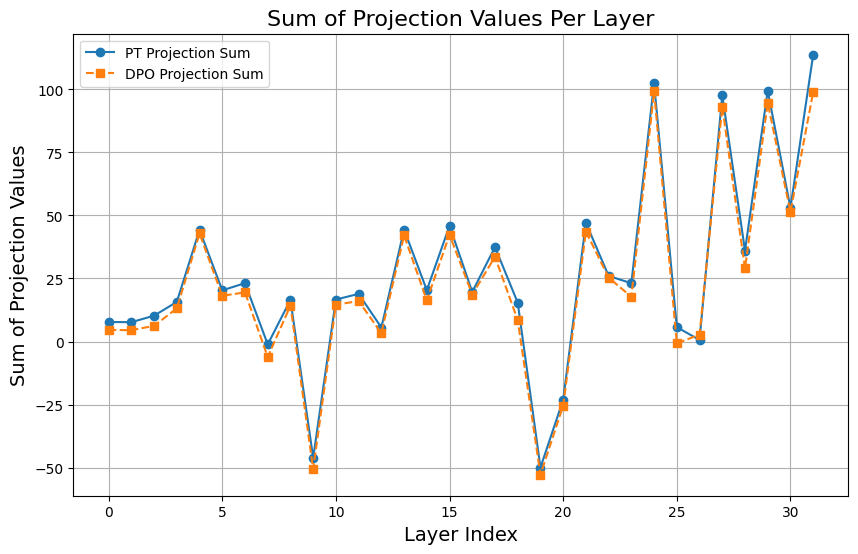

In [38]:
# Group by layer_index and compute the sum for pt_projection_value and dpo_projection_value
layer_sums = merged_df.groupby("layer_idx")[["pt_projection_value", "dpo_projection_value"]].sum().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))

# Plot PT projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["pt_projection_value"], label="PT Projection Sum", marker='o', linestyle='-')

# Plot DPO projection sum
plt.plot(layer_sums["layer_idx"], layer_sums["dpo_projection_value"], label="DPO Projection Sum", marker='s', linestyle='--')

# Labels and title
plt.xlabel("Layer Index", fontsize=14)
plt.ylabel("Sum of Projection Values", fontsize=14)
plt.title("Sum of Projection Values Per Layer", fontsize=16)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


##### Cumulative sum plot

In [14]:
df = merged_df

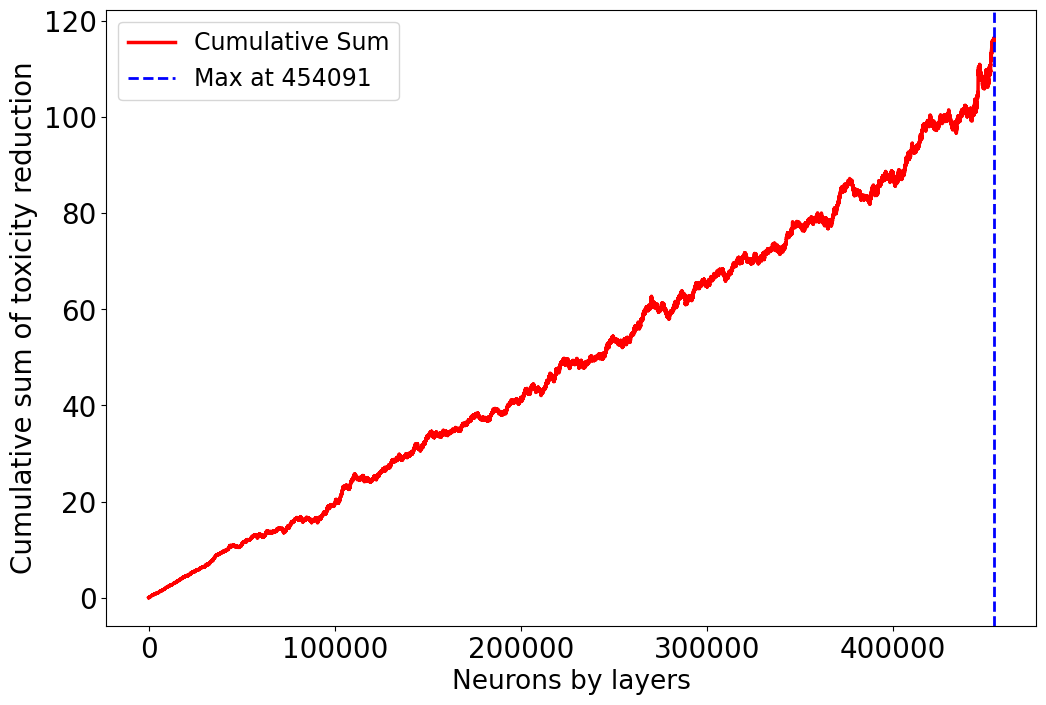

In [15]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Neurons by layers", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

In [17]:
df = df.sort_values(by="projection_diff", ascending=False)

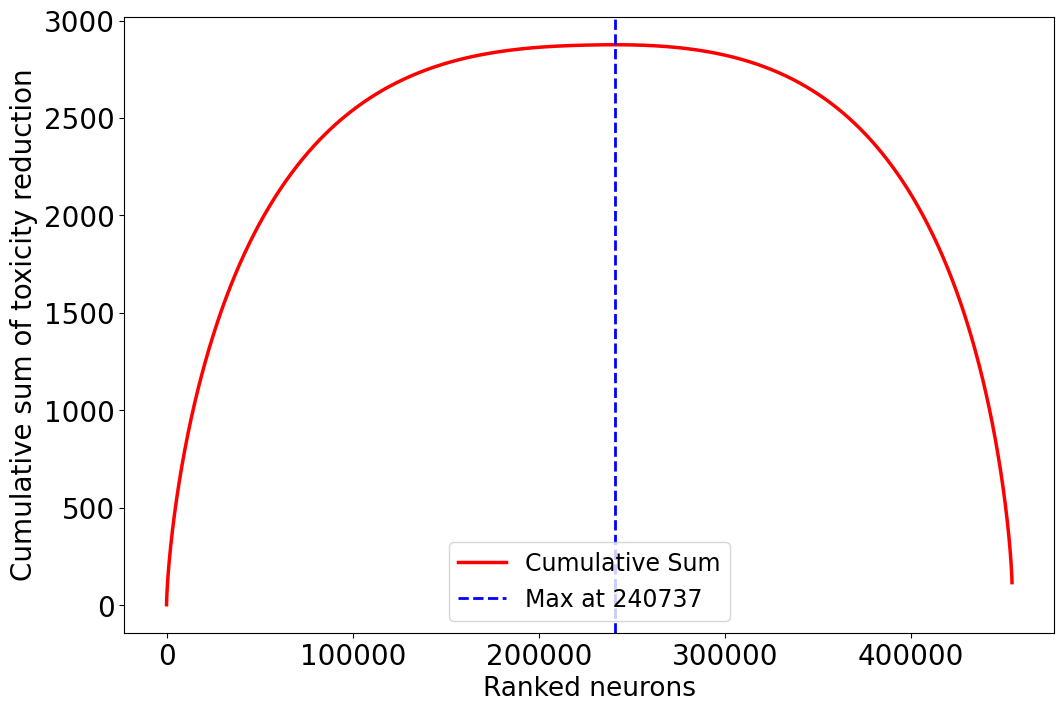

In [18]:
# Initialize an empty list for the cumulative sum
cumsum_values = []

# Manually calculate the cumulative sum
current_sum = 0
for value in df['projection_diff']:
    current_sum += value
    cumsum_values.append(current_sum)

# Find the index where the cumulative sum reaches its maximum
max_cumsum_index = np.argmax(cumsum_values)

# Plot the manually calculated cumulative sum
plt.figure(figsize=(12, 8))
plt.plot(cumsum_values, label='Cumulative Sum', color='r', linewidth=2.5)  # Increased linewidth

# Add a vertical line at the maximum cumulative sum
plt.axvline(x=max_cumsum_index, color='b', linestyle='--', linewidth=2, label=f'Max at {max_cumsum_index}')  # Increased linewidth

# Add labels and title
# plt.title("Cumulative sum of toxicity reduction contributed by neurons", fontsize=18)
plt.xlabel("Ranked neurons", fontsize=19)
plt.ylabel("Cumulative sum of toxicity reduction", fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
plt.legend(fontsize=17)

# Show the plot
# plt.grid(True)
plt.show()

#### Array plot

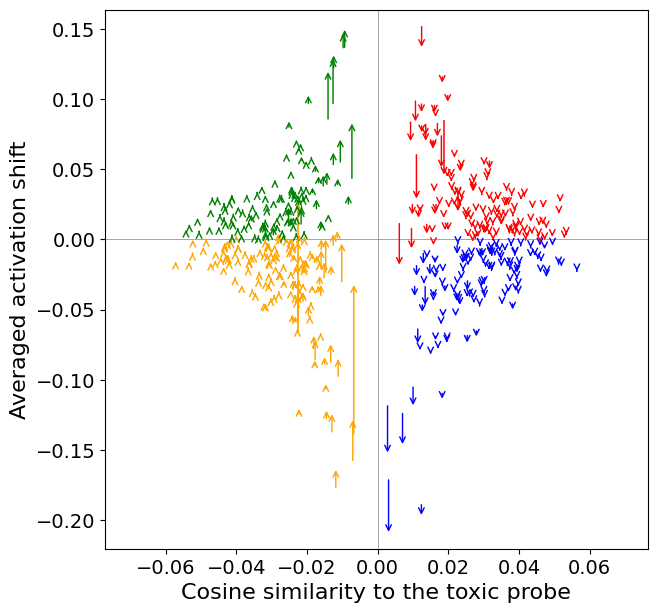

In [5]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).head(500)

# Define x and y variables
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
# top_contrib = top_contrib[
#     ((top_contrib["pt_cosine_similarity"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
#     ((top_contrib["pt_cosine_similarity"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
# ]

# Final inputs for plot
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

contrib = top_contrib["projection_diff"]
contrib = contrib / max(contrib) # Normalise

width_boost = 1.2
contrib = np.clip(contrib / max(contrib) * width_boost, 0, 1)
width = contrib / max(contrib) * width_boost - contrib + 1

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=16)
ax.set_ylabel("Averaged activation shift", fontsize=16)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=_width,
        ),
    )

plt.show()

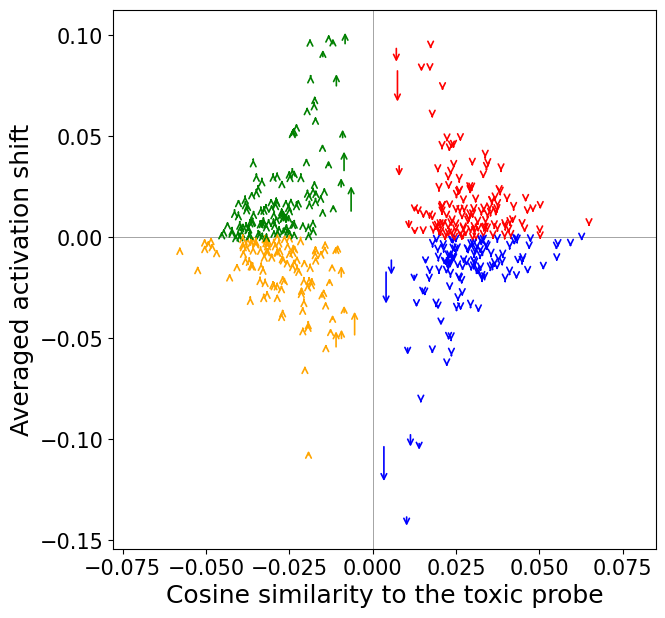

In [6]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).iloc[1000:1500]

# Define x and y variables
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
# top_contrib = top_contrib[
#     ((top_contrib["pt_cosine_similarity"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
#     ((top_contrib["pt_cosine_similarity"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
# ]

# Final inputs for plot
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

contrib = top_contrib["projection_diff"]
contrib = contrib / max(contrib) # Normalise

width_boost = 1.2
contrib = np.clip(contrib / max(contrib) * width_boost, 0, 1)
width = contrib / max(contrib) * width_boost - contrib + 1

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=_width,
        ),
    )

plt.show()

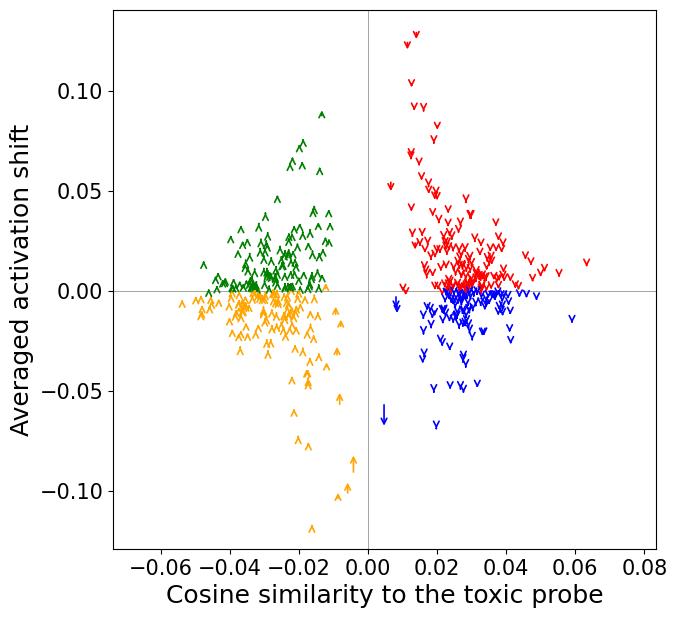

In [7]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).iloc[2000:2500]

# Define x and y variables
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
# top_contrib = top_contrib[
#     ((top_contrib["pt_cosine_similarity"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
#     ((top_contrib["pt_cosine_similarity"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
# ]

# Final inputs for plot
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

contrib = top_contrib["projection_diff"]
contrib = contrib / max(contrib) # Normalise

width_boost = 1.2
contrib = np.clip(contrib / max(contrib) * width_boost, 0, 1)
width = contrib / max(contrib) * width_boost - contrib + 1

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=_width,
        ),
    )

plt.show()

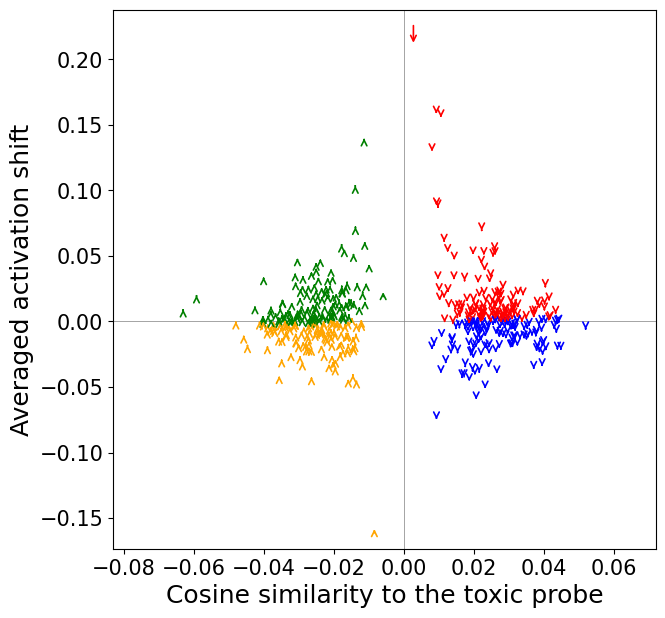

In [8]:
# Top contributing neurons
top_contrib = df.sort_values(by="projection_diff", ascending=False).iloc[4000:4500]

# Define x and y variables
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]

# Activation shift outlier removal for display
lower_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.005).min()
upper_q = top_contrib[["pt_activation_value", "dpo_activation_value"]].quantile(0.995).max()

top_contrib = top_contrib[
    (top_contrib["pt_activation_value"].between(lower_q, upper_q)) &
    (top_contrib["dpo_activation_value"].between(lower_q, upper_q))
]

# - toxic neurons: positive cossim + activation drop
# - anti-toxic neurons: negative cossim + activation rise
# top_contrib = top_contrib[
#     ((top_contrib["pt_cosine_similarity"] > 0) & (top_contrib["dpo_activation_value"] < top_contrib["pt_activation_value"])) |
#     ((top_contrib["pt_cosine_similarity"] < 0) & (top_contrib["dpo_activation_value"] > top_contrib["pt_activation_value"]))
# ]

# Final inputs for plot
x1 = top_contrib["pt_cosine_similarity"]
x2 = top_contrib["dpo_cosine_similarity"]
y1 = top_contrib["pt_activation_value"]
y2 = top_contrib["dpo_activation_value"]

contrib = top_contrib["projection_diff"]
contrib = contrib / max(contrib) # Normalise

width_boost = 1.2
contrib = np.clip(contrib / max(contrib) * width_boost, 0, 1)
width = contrib / max(contrib) * width_boost - contrib + 1

fig, ax = plt.subplots(figsize=(7, 7))

# Increase label font size
ax.set_xlabel("Cosine similarity to the toxic probe", fontsize=18)
ax.set_ylabel("Averaged activation shift", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=15)

_xpad = 0.02
_ypad = 0.01
ax.set_xlim(min(min(x1), min(x2)) - _xpad, max(max(x1), max(x2)) + _xpad)
ax.set_ylim(min(min(y1), min(y2)) - _ypad, max(max(y1), max(y2)) + _ypad)

ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

for _x1, _x2, _y1, _y2, _contrib, _width in zip(x1, x2, y1, y2, contrib, width):
    if _x1 > 0:
        if _y1 > 0:
            color = "r"  # toxic neuron with positive activation
        else:
            color = "b"  # toxic neuron with negative activation
    else:
        if _y1 > 0:
            color = "g"  # anti-toxic neuron with positive activation
        else:
            color = "orange"  # anti-toxic neuron with negative activation

    ax.annotate(
        "",
        xy=(_x2, _y2),
        xytext=(_x1, _y1),
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            linewidth=_width,
        ),
    )

plt.show()

##### Stacked bar plot

#tp 61319
#tn 58913
#atp 59169
#atn 61337
#total 240738

tp   26%
tn   24%
atp  24%
atn  26%


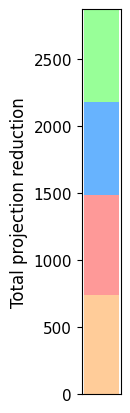

In [26]:
# %%
inc = df[df["projection_diff"] > 0]
# %%
tp = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] > 0)]
tn = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] <= 0)]
atp = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] > 0)]
atn = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] <= 0)]

print(f"#tp {len(tp)}")
print(f"#tn {len(tn)}")
print(f"#atp {len(atp)}")
print(f"#atn {len(atn)}")
print(f"#total {len(inc)}")
assert len(inc) == len(tp) + len(tn) + len(atp) + len(atn)

tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()
total_sum = inc["projection_diff"].sum()
print()
print(f"tp   {tp_sum/total_sum:.0%}")
print(f"tn   {tn_sum/total_sum:.0%}")
print(f"atp  {atp_sum/total_sum:.0%}")
print(f"atn  {atn_sum/total_sum:.0%}")


# bar plot of tp
fig, ax = plt.subplots(figsize=(0.5, 5))
ax.bar(0, atn_sum, label="anti-toxic negative", color="#FFCC99")
_b = atn_sum
ax.bar(0, tp_sum, bottom=_b, label="toxic positive", color="#FE9998")
_b += tp_sum
ax.bar(0, tn_sum, bottom=_b, label="toxic negative", color="#67B3FE")
_b += tn_sum
ax.bar(0, atp_sum, bottom=_b, label="anti-toxic positive", color="#98FF98")
_b += atp_sum

# set lim
ax.set_ylim(0, total_sum)
# y axis total group contribution
ax.set_ylabel("Total projection reduction", fontsize=12)
# remove x ticks
ax.set_xticks([])
# Increase the size of the tick labels
ax.tick_params(axis='both', which='major', labelsize=11)

# axs.append(ax)

##### Per-layer graphs

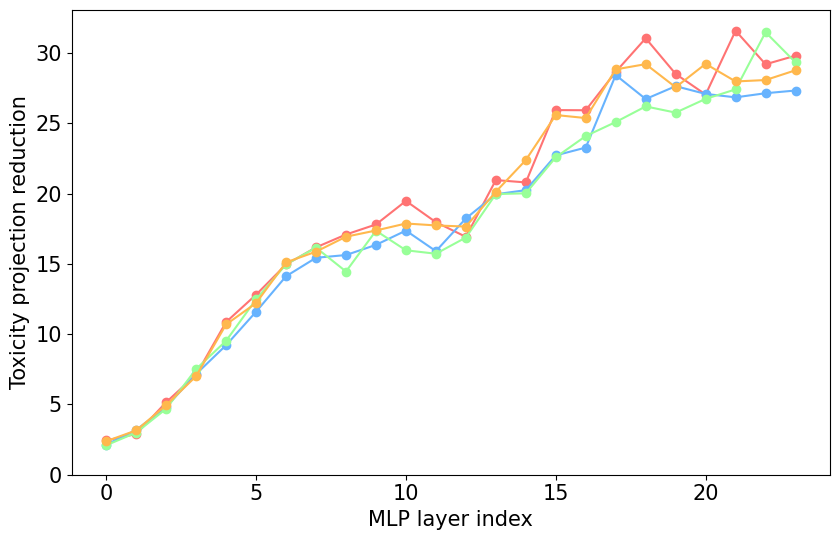

In [10]:
# Define group colors for consistency
colors = ['#FF7373', '#67B3FE', '#98FF98', '#FFB84D']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Filter data for positive projection differences
    inc = layer_df[layer_df["projection_diff"] > 0]

    # Apply the same filtering as before
    tp = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] > 0)]
    tn = inc[(inc["pt_cosine_similarity"] > 0) & (inc["pt_activation_value"] <= 0)]
    atp = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] > 0)]
    atn = inc[(inc["pt_cosine_similarity"] <= 0) & (inc["pt_activation_value"] <= 0)]
    
    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(8.5, 5.5))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='TP↓: Toxic-aligned neurons, positively activated', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='TN↓: Toxic-aligned neurons, negatively activated', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='AP↓: Anti-toxic-aligned neurons, positively activated', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='AN↓: Anti-toxic-aligned neurons, negatively activated', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
# ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP layer index', fontsize=15)
ax.set_ylabel('Toxicity projection reduction', fontsize=15)
# ax.set_title('Toxicity reduction per layer contributed by neuron groups', fontsize=14)

# Add a legend to indicate which line corresponds to which group
# ax.legend(fontsize=14)

# Set xticks and yticks with increased font size
ax.set_xticks(range(0, 25, 5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Define y-axis limits to start from 0
ax.set_ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()

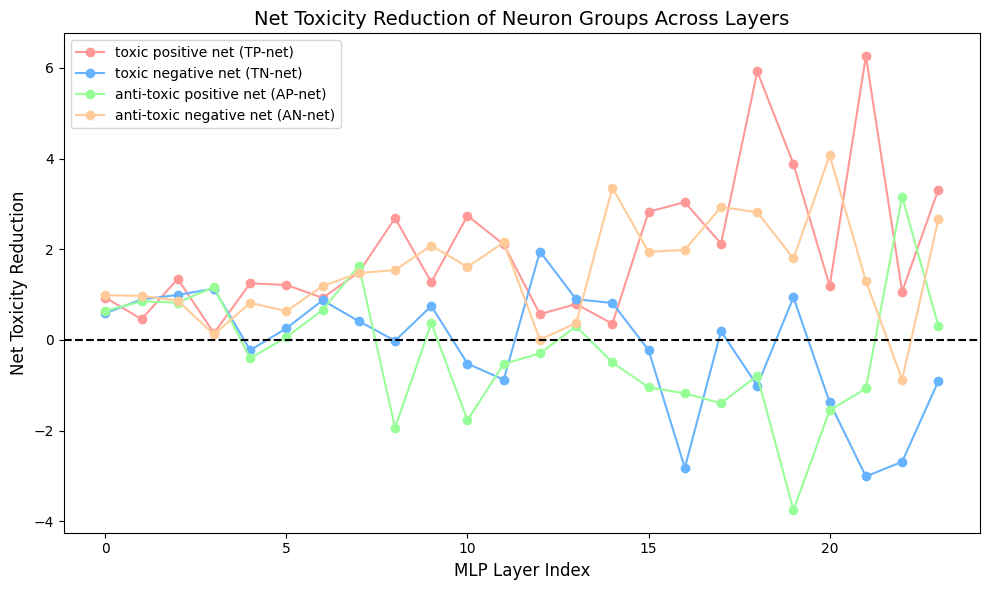

In [24]:
# Define group colors for consistency
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']

# Initialize lists to store the sums of projection_diff for each group in each layer
tp_sums, tn_sums, atp_sums, atn_sums = [], [], [], []

# Iterate through each layer and compute the projection_diff sums for each group
layers_to_plot = range(24)

for layer in layers_to_plot:
    # Filter neurons by layer
    layer_df = df[df['layer_idx'] == layer]

    # Apply the same filtering as before, but without filtering out projection_diff <= 0
    tp = layer_df[(layer_df["pt_cosine_similarity"] > 0) & (layer_df["pt_activation_value"] > 0)]
    tn = layer_df[(layer_df["pt_cosine_similarity"] > 0) & (layer_df["pt_activation_value"] <= 0)]
    atp = layer_df[(layer_df["pt_cosine_similarity"] <= 0) & (layer_df["pt_activation_value"] > 0)]
    atn = layer_df[(layer_df["pt_cosine_similarity"] <= 0) & (layer_df["pt_activation_value"] <= 0)]

    # Calculate the sum of projection_diff for each group in this layer
    tp_sums.append(tp["projection_diff"].sum())
    tn_sums.append(tn["projection_diff"].sum())
    atp_sums.append(atp["projection_diff"].sum())
    atn_sums.append(atn["projection_diff"].sum())

# Prepare data for plotting the lines for each group
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each group
ax.plot(layers_to_plot, tp_sums, label='toxic positive net (TP-net)', color=colors[0], marker='o')
ax.plot(layers_to_plot, tn_sums, label='toxic negative net (TN-net)', color=colors[1], marker='o')
ax.plot(layers_to_plot, atp_sums, label='anti-toxic positive net (AP-net)', color=colors[2], marker='o')
ax.plot(layers_to_plot, atn_sums, label='anti-toxic negative net (AN-net)', color=colors[3], marker='o')

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_xlabel('MLP Layer Index', fontsize=12)
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups Across Layers', fontsize=14)

# Add a legend to indicate which line corresponds to which group
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_2307859/3333071173.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)


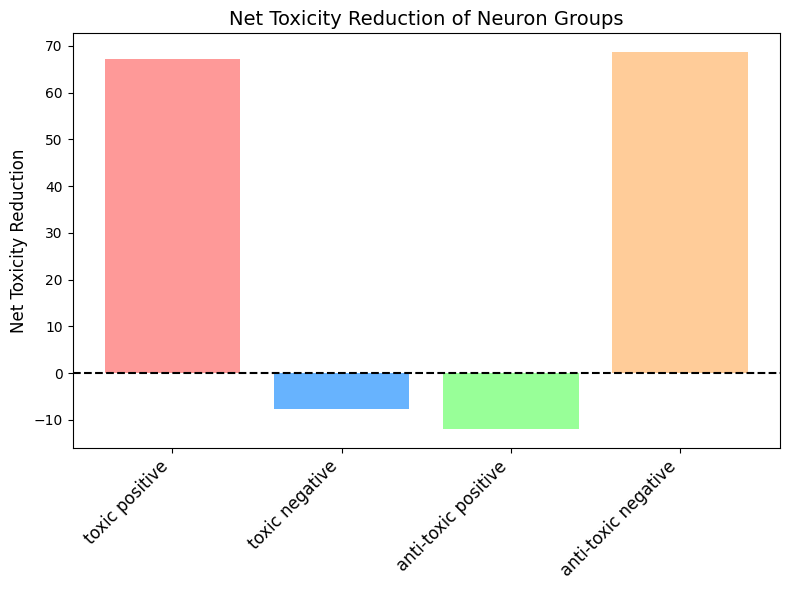

In [25]:
# Calculate the net sums across all layers for the four groups
tp = df[(df["pt_cosine_similarity"] > 0) & (df["pt_activation_value"] > 0)]
tn = df[(df["pt_cosine_similarity"] > 0) & (df["pt_activation_value"] <= 0)]
atp = df[(df["pt_cosine_similarity"] <= 0) & (df["pt_activation_value"] > 0)]
atn = df[(df["pt_cosine_similarity"] <= 0) & (df["pt_activation_value"] <= 0)]

# Calculate the total sum of projection_diff for each group
tp_sum = tp["projection_diff"].sum()
tn_sum = tn["projection_diff"].sum()
atp_sum = atp["projection_diff"].sum()
atn_sum = atn["projection_diff"].sum()

# Prepare data for plotting
group_sums = [tp_sum, tn_sum, atp_sum, atn_sum]
group_labels = ['toxic positive', 'toxic negative', 'anti-toxic positive', 'anti-toxic negative']
colors = ['#FE9998', '#67B3FE', '#98FF98', '#FFCC99']

# Plot the net effect for all neurons across all layers
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot
ax.bar(group_labels, group_sums, color=colors)

# Add a horizontal line at y=0 for clarity
ax.axhline(y=0, color='black', linestyle='--')

# Set labels and title
ax.set_ylabel('Net Toxicity Reduction', fontsize=12)
ax.set_title('Net Toxicity Reduction of Neuron Groups', fontsize=14)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

##### Notes: 
(1) Green is always negative, is it the main tradeoff point?

(2) Blue decreases from positive (top 1 group) to negative, as another tradeoff point?

##### Frequency bar plot

In [12]:
df = df.sort_values(by="projection_diff", ascending=False)

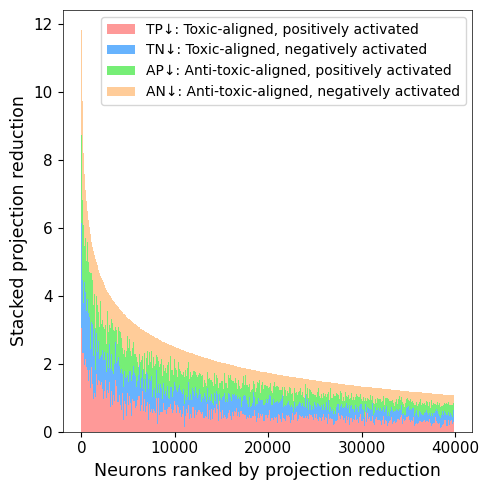

In [16]:
# Top 100-40000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(100, 40000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] > 0)]
    tn = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] <= 0)]
    atp = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] > 0)]
    atn = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP↓: Toxic-aligned, positively activated", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN↓: Toxic-aligned, negatively activated", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP↓: Anti-toxic-aligned, positively activated", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN↓: Anti-toxic-aligned, negatively activated", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by projection reduction", fontsize=12.5, fontweight='normal', labelpad=4)
ax.set_ylabel("Stacked projection reduction", fontsize=12.5)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=11)

# Enlarging the legend
ax.legend(fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(0.5) 

plt.tight_layout()
plt.show()

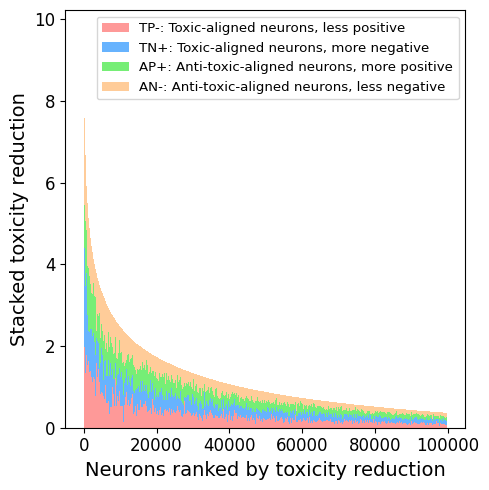

In [15]:
# Top 200-10000 contributing neurons (omit first 100 for better displaying)
chunk_size = 50
tp_contribs = []
tn_contribs = []
atp_contribs = []
atn_contribs = []
for i in range(200, 100000, chunk_size):
    chunk = df[i : i + chunk_size]
    tp = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] > 0)]
    tn = chunk[(chunk["pt_cosine_similarity"] > 0) & (chunk["pt_activation_value"] <= 0)]
    atp = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] > 0)]
    atn = chunk[(chunk["pt_cosine_similarity"] <= 0) & (chunk["pt_activation_value"] <= 0)]
    tp_contribs.append(tp["projection_diff"].sum())
    tn_contribs.append(tn["projection_diff"].sum())
    atp_contribs.append(atp["projection_diff"].sum())
    atn_contribs.append(atn["projection_diff"].sum())
    
# bar plot of tp
fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(len(tp_contribs)) * chunk_size
# adjust width
w = 1.0 * chunk_size

# instead, stack bars one on another
ax.bar(x, tp_contribs, label="TP-: Toxic-aligned neurons, less positive", color="#FE9998", width=w)
_b = np.array(tp_contribs)
ax.bar(x, tn_contribs, bottom=_b, label="TN+: Toxic-aligned neurons, more negative", color="#67B3FE", width=w)
_b += np.array(tn_contribs)
ax.bar(x, atp_contribs, bottom=_b, label="AP+: Anti-toxic-aligned neurons, more positive", color="#76EE76", width=w)
_b += np.array(atp_contribs)
ax.bar(x, atn_contribs, bottom=_b, label="AN-: Anti-toxic-aligned neurons, less negative", color="#FFCC99", width=w)
ax.legend()

# label axes
ax.set_xlabel("Neurons ranked by toxicity reduction", fontsize=14)
ax.set_ylabel("Stacked toxicity reduction", fontsize=14)

# Increasing the size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Enlarging the legend
ax.legend(fontsize=9.6)

plt.tight_layout()
plt.show()